In [ ]:
#What is our main question? 

#1. Are hospitals overcharging patients? Which ones. if yes, then which price are they overcharging. 

#Hospitals are overcharging patients. Nadia thinks that between the cashprize and max _ng, you pick max of the two, and make a new column. 

#Through the analysis, we want to flag hospitals that have a S.D more than the mean price. Those places are probably overcharging.

#We can run a test to see if colonoscopy and CT scan and see if a hospital is consistenly more expensive. for example Ascension always charges more.  

In [ ]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
import folium  #needed for interactive map
from folium.plugins import HeatMap
%matplotlib inline
sns.set()
import glob
import re
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import statsmodels.formula.api as sm

In [ ]:
df_hospital = pd.read_csv('df_hospital_clean.csv')
df_price = pd.read_csv('df_price_clean.csv')
df_pop = pd.read_csv('df_population.csv')

In [ ]:
df_hospital['zip_code'] = df_hospital['zip_code'].astype('string')
df_price['cpt_code'] = df_price['cpt_code'].astype('string')

Note: Important to create a df that differs on procedure to be able to compare prices for procedures. 

In [ ]:
#List procedure codes
ls_code = [
    "45378",
    "59409",
    "70450",
    "99203",
    "70551",
    "85025",
    "85027"
]

#List of pricing
ls_price = [
    "gross_charge",
    "cash_price",
    "min_ng",
    "max_ng"
]

d = {
    "45378": 'colon', 
    "59409": 'delivery', 
    "70450": 'headCT', 
    "99203": 'visit', 
    "70551": "brainMRI", 
    "85025": "bloodCount", 
    "85027": 'blood_bloodCountDiff'
    }

ls_procedure = [
    'colon', 
    'delivery', 
    'headCT', 
    'visit', 
    "brainMRI", 
    "bloodCount", 
    'blood_bloodCountDiff'
    ]


In [ ]:
df = pd.merge(df_hospital, df_price, on="hospital_name", how = 'inner')
df = pd.merge(df, df_pop, on="county_name", how = "inner")
df['cpt_name'] = df['cpt_code'].map(d)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590 entries, 0 to 589
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   hospital_name     590 non-null    object 
 1   system            590 non-null    object 
 2   facility          590 non-null    object 
 3   county_name       590 non-null    object 
 4   zip_code          490 non-null    string 
 5   capacity          526 non-null    float64
 6   revenue           509 non-null    float64
 7   ownership         526 non-null    object 
 8   urban             543 non-null    object 
 9   type              526 non-null    object 
 10  tps_score         521 non-null    float64
 11  cpt_code          590 non-null    string 
 12  description       558 non-null    object 
 13  gross_charge      569 non-null    float64
 14  cash_price        500 non-null    float64
 15  min_ng            435 non-null    float64
 16  max_ng            435 non-null    float64
 1

In [ ]:
df = df[['gross_charge','cash_price','min_ng','max_ng','household_income','pop_density','children_percent','senior_percent','sex_ratio','white_percent','unemployment','high_school','uninsured','life_exp','pcp_ratio']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [ ]:
df_new['cpt_code'] = df['cpt_code'].map(d)
df_new.head()

,gross_charge,cash_price,min_ng,max_ng,household_income,pop_density,children_percent,senior_percent,sex_ratio,white_percent,unemployment,high_school,uninsured,life_exp,pcp_ratio,cpt_name,cpt_code
0,0.100572,0.087373,0.051880,0.025642,0.362705,0.164284,0.804667,0.09037,0.112903,0.640662,0.107143,0.9,0.166667,0.608696,0.087968,headCT,headCT
1,0.087945,0.076433,0.143375,0.069442,0.362705,0.164284,0.804667,0.09037,0.112903,0.640662,0.107143,0.9,0.166667,0.608696,0.087968,brainMRI,brainMRI
2,0.003297,0.003069,0.001524,0.000532,0.362705,0.164284,0.804667,0.09037,0.112903,0.640662,0.107143,0.9,0.166667,0.608696,0.087968,bloodCount,bloodCount
3,0.217189,0.188411,NaN,NaN,0.362705,0.164284,0.804667,0.09037,0.112903,0.640662,0.107143,0.9,0.166667,0.608696,0.087968,delivery,delivery
4,0.006635,0.005985,NaN,NaN,0.362705,0.164284,0.804667,0.09037,0.112903,0.640662,0.107143,0.9,0.166667,0.608696,0.087968,visit,visit


Start with Colon data 

In [ ]:
for z in ls_code:
    formula1 = "cash_price ~ uninsured + pop_density + household_income + white_percent + tps_score + pcp_ratio + children_percent + sex_ratio + unemployment + senior_percent + high_school + life_exp"
    df_stat = df.loc[df['cpt_code'] == z] 
    model1 = sm.ols(formula = formula1, data = df_stat)
    fitted1 = model1.fit()
    print("Regression analysis for " + df_stat["cpt_name"].iloc[2])
    print(fitted1.summary())
    print("\n")   

In [ ]:
def box_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    series = series[mask]
    return series

data_outliers = pd.DataFrame([])

appended_data = []

for z in ls_price:
    for i in df.copy().cpt_name.unique():
        df_outlier = df.copy().sort_values(['cpt_name'])
        df_outlier = df_outlier.loc[df_outlier['cpt_name'] == i, :].reset_index(drop=True)
        df_outlier = df_outlier[['cpt_name', z]].set_index('cpt_name').apply(box_outliers)
        df_outlier = df_outlier.reset_index()
        data_outliers = data_outliers.append(df_outlier) 
        #data_outliers.reset_index(drop=True)
        
        q1 = df[z].quantile(0.25)
        q3 = df[z].quantile(0.75)
        IQR = q3 - q1
        mean_price = df[z].quantile(0.5)
        top_bar = q3 + 1.5 * IQR

        df['price_type'] = z
        df['price'] = df[z]
        df_outlier = pd.merge(df, df_outlier, on=['cpt_name', z], how = "inner")
        appended_data.append(df_outlier)

appended_data = pd.concat(appended_data).reset_index()        
appended_data     

ls_outlier = [
    "revenue",
    "household_income",
    "tps_score"
]

for x in ls_code:
    df_outlier = appended_data.loc[appended_data['cpt_code'] == x]
    print(df_outlier["cpt_name"].iloc[2])
    for z in ls_price:
        df_outlier = appended_data.loc[appended_data['price_type'] == z]
        df_outlier = appended_data.loc[appended_data['cpt_code'] == x]
        print(z)
        print(df_outlier.system.value_counts())
        print("Total count: " + str(df_outlier[df_outlier.columns[0]].count()))
        for y in ls_outlier:
            df_outlier = appended_data.loc[appended_data['price_type'] == z]
            df_outlier = appended_data.loc[appended_data['cpt_code'] == x]
            print(y + ": " + "{:,}".format(df_outlier[y].quantile(0.5)) + " vs " + "{:,}".format(df[y].quantile(0.5)))
        print("\n")

colon
gross_charge
Detroit Medical Center      11
Ascension Michigan           5
Munson Healthcare            1
Bronson Healthcare Group     1
Name: system, dtype: int64
Total count: 18
revenue: 1,250,000,000.0 vs 411,000,000.0
household_income: 54,750.0 vs 52,300.0
tps_score: 18.38 vs 30.5


cash_price
Detroit Medical Center      11
Ascension Michigan           5
Munson Healthcare            1
Bronson Healthcare Group     1
Name: system, dtype: int64
Total count: 18
revenue: 1,250,000,000.0 vs 411,000,000.0
household_income: 54,750.0 vs 52,300.0
tps_score: 18.38 vs 30.5


min_ng
Detroit Medical Center      11
Ascension Michigan           5
Munson Healthcare            1
Bronson Healthcare Group     1
Name: system, dtype: int64
Total count: 18
revenue: 1,250,000,000.0 vs 411,000,000.0
household_income: 54,750.0 vs 52,300.0
tps_score: 18.38 vs 30.5


max_ng
Detroit Medical Center      11
Ascension Michigan           5
Munson Healthcare            1
Bronson Healthcare Group     1
Name: s

In [ ]:
import plotly.express as px

for z in ls_price:
    fig = px.box(df, x = 'cpt_name', y = z, title = z, points="all", hover_data=["system", "description", "urban"])
    fig.show()


This shows us that we need to check our pricing data and chooose correct descripton or a description that is closely realted to the procedure we are trying to solve. This is a very skewed curve indicative of that fact that we are mixing diagnostic capabilities with a colonoscopy procedure. 

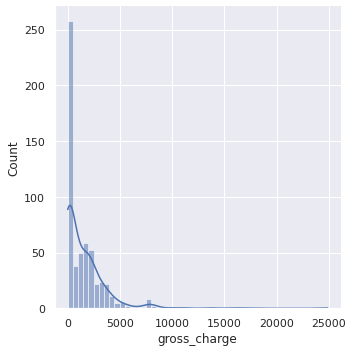

In [ ]:
sns.displot(df, x = 'gross_charge', kde = True)

Other - Nadia's analysis. 

What does the team do?

1. Kasole can take our merged data and add UMichigan data. We run the KNN imputation on that new data set. Kasole adds analysis of his own.
2. Amber choose three procedures and runs the same analysis. Add analysis of her own. Please write your findings. Whose the highest hospital price? Do they also have a high score. 
3. Evelyn chooses two procedures and runs the same analysis. Add analysis of her own. Please write your findings. 
4. Nadia takes one procedures and does the geo mapping data for all. Nadia to also figure out a way to divide by hospital. 
